In [2]:
import os
import PIL
import matplotlib.pyplot as plt 
import numpy as np
import cv2 
import time
import glob

In [5]:
H5 = '/media/f4h1m/Dell External/CSE3200/Binary_classification/project-2/preprocessed_dataset/H5'
H6 = '/media/f4h1m/Dell External/CSE3200/Binary_classification/project-2/preprocessed_dataset/H6'


files_H5 = glob.glob(H5+ '/*.jpg')
files_H6 = glob.glob(H6+ '/*.jpg')

In [6]:
X_data = []
y_labels = []


for file in files_H5:
    image = cv2.imread(file)
    X_data.append(image)
    y_labels.append(0)

for file in files_H6:
    image = cv2.imread(file)
    X_data.append(image)
    y_labels.append(1)


In [7]:
X_sets = np.array(X_data)
m = X_sets.shape[0] #no of samples
features_array = X_sets.reshape(X_sets.shape[0], -1).T # The rows represent the features, column represent the amount of samples

y_labels = np.array(y_labels) #making it into a NumPy Array
y =  y_labels.reshape(1,-1) # Remember that your output must be size (1,m)
x  = features_array/255.0 #Normalise

  
# Randomly shuffling the datasets (Just in case it was set up in an orderly fashioned):
# which in our case it is set up into two organised datasets so shuffling is a MUST
 
permutation = list(np.random.permutation(m))
shuffled_X = x[:, permutation]
shuffled_Y = y[:, permutation] 

# Now split X and Y to training and test sets:

# ~Percent % for training, ~Percent % for testing . (I am thinking it is too small to include dev sets)

percent = 0.85  # Tune this to how much percent of training and test samples do you want.

train_x =  shuffled_X[:,0:int(percent*m)]
train_y =  shuffled_Y[:,0:int(percent*m)]

test_x  = shuffled_X[:,int(percent*m):]
test_y  = shuffled_Y[:,int(percent*m):]

print('Dataset is ready')


Dataset is ready


Dataset is ready
Cost after epoch 0: 3.464953
Cost after epoch 50: 0.675175
Cost after epoch 100: 0.511598
Cost after epoch 150: 0.415568
Cost after epoch 200: 0.416483
Cost after epoch 250: 0.445599
Cost after epoch 300: 0.419822
Cost after epoch 350: 0.414809
Cost after epoch 400: 0.461533


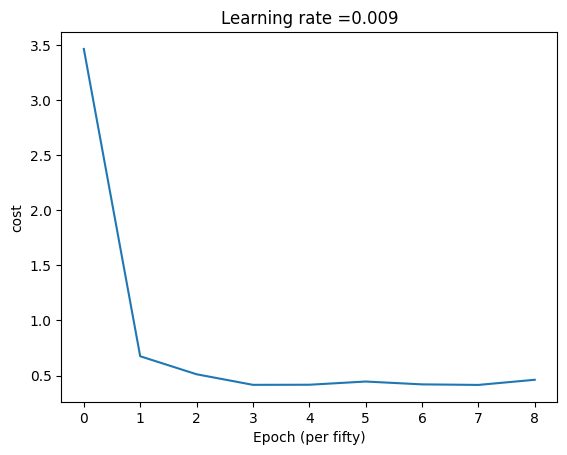

Process Time:1469.4409112930298 seconds
Accuracy of training sets: 0.7882352941176471
Accuracy of testing sets: 0.7333333333333334


In [9]:
def initialise_parameters(layer_dims): # initialising forward propagation values
    # Takes in the dimensions required for your neutral network (Layer Dimension)
    # layers_dims = ( size of features (n_x),  size of hidden layer 1 (n_h1),...(size of other n_h)...., size of output (n_y))
    
    parameters = {} # Dictionary Type, easy access for variable name using key
    L = len(layer_dims) # Number of layers wanted from neural network

    for i in range(1,L): #Note: Range does not take upper bound number (which is what we want as input layer is not part of the hidden layer)
        # Number of hidden layers = Number of weight and bias matrix needed
       
        
        parameters["W" + str(i)] =  np.random.randn(layers_dims[i], layers_dims[i-1]) * (np.sqrt(2 / layers_dims[i-1] ))   # Weight Matrix 
        parameters["B" + str(i)] =  np.zeros((layers_dims[i], 1))  # Bias Matrix (size: 1 column)
   

    return  parameters   # Returning parameters needed for forward propagation

def initialise_past(parameters):
    
    L = len(parameters) // 2 # Number of hidden layers wanted from neural network
    past = {} #initialising dictionary
    
    for i in range(1,L+1):
   
     past["dW" + str(i)] = parameters["W" + str(i)] * 0.0 #same dimensions
     past["dB" + str(i)] = parameters["B" + str(i)] * 0.0 #same dimensions

    return past

# Forward Propagation: (For now just do sigmoid for all)..........................
    
def sigmoid(x):  # Sigmoid Function
  return  1 / (1 + np.exp(-x))


def forward_activation(A_prev, W , b , activation):
    
    Z = np.dot(W,A_prev) + b  # Z: Value to put into function (sigmoid/ReLu) to get next activation unit
    linear_cache = (A_prev,W,b) # Cache for backward propagation
    # A: Activation Unit, W: Weight, b: bias
       
    if activation == "sigmoid": 
       A = sigmoid(Z) # next activation unit
       activation_cache  = Z
       
    elif activation == "relu":
        A = np.maximum(0,Z) # Activation through relu
        activation_cache = Z
    
    assert(Z.shape == (W.shape[0], A_prev.shape[1]))
    
    cache = (linear_cache, activation_cache)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    
    return A,cache


    
def forward_propagate(X, parameters):
    
    caches = [] #Initialise empty cache (to append later on)
    A = X # initial Activation unit is the input features
    L = len(parameters) // 2 # Getting the length of hidden layer (Note: it is floor-ed cause indexes cannot take in float)
    
    for i in range(1,L): #remember the last weight is not included
        A_prev  =  A #Current Activation Unit value that was calculated (Starting with inputs)
        A,cache =  forward_activation(A_prev, parameters["W"+str(i)] , parameters["B"+str(i)] , "relu")
        caches.append(cache)
    
    #For last activation: use sigmoid
    
    A_Last,cache =  forward_activation(A, parameters["W"+str(L)] , parameters["B"+str(L)] , "sigmoid") #calculating last activation unit
    caches.append(cache)
    
    
    return A_Last, caches
    
#...............................................................................  
    

#Computing Cost
def compute_regularised_cost(A_Last, Y,caches,lambd): # A_Last: Last activation unit (prediction) , Y: Data Output
    
     m  = Y.shape[1]  # Number of training samples ( Make sure output is size(1,Samples) )
     L = len(caches)  # Length of hidden layers
     total = 0 # will be broadcasted by weights
     
     for i in range(L):
         
        linear_cache, _ = caches[i]# from forward propagation
        _ , W, _ = linear_cache
        
        summing = np.sum(W**2)
        total  = total + summing
     
     cost = -(1/m) * ( np.dot(Y, np.log(A_Last).T)  +  np.dot( (1-Y), np.log(1-A_Last).T) ) # Using logarithmic cost function 
     
     cost = np.squeeze(cost) # ensure cost array of size (1,1) to become just a singular number 
     # Squeeze is important as array multiplication in python always gives back an array
    
     reg_cost = (lambd/(2*m)) * total
     regularised_cost = cost + reg_cost
     
     return regularised_cost 


    

   
# Backward Propagation:........................................................
     
def backward_linear(dZ , cache ,lambd):
    
    A_prev, W, b = cache # From forward propogation 
    m = A_prev.shape[1] # Column of input features/activation units =  number of samples 
    
    # Backprop Gradient formula
    dW = 1./m * np.dot(dZ,A_prev.T) + ((lambd/m) * W)
    db = 1./m *  np.sum(dZ, axis = 1, keepdims =True) 
    dA_prev = np.dot(W.T,dZ)
        
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db
    
def backward_activation(dA , cache , activation , lambd):
    
    linear_cache, activation_cache = cache
    
      
    if activation == "relu":
        
        Z = activation_cache
        
        dZ = np.array(dA, copy=True) # check what does copy do in numpy array. ( Conversion to correct object)       
        #dA is the derivative of dZ when above 0, think of y = x, dA/dZ  = 1
        dZ[Z <= 0] = 0   #Logical index, when Z <= 0 , dZ will be = 0
     
        
        dA_prev, dW, db = backward_linear(dZ, linear_cache,lambd) # getting the gradient for linear calculations
        
        
    elif activation == "sigmoid":
        
        Z = activation_cache 
        
        dZ =  dA  * sigmoid(Z)  * ( 1-sigmoid(Z) )  # Derivative for Sigmoid activation function (dZ)
        dA_prev, dW, db = backward_linear(dZ, linear_cache,lambd) # getting the gradient for linear calculations

    
    return dA_prev, dW, db
    
 
def backward_propagate(A_Last,Y,caches,lambd):
    
    gradients = {}
    L = len(caches) # Number of hidden layer
    Y = Y.reshape(A_Last.shape)  #Make sure outputs follows the same shape as the last activation unit
    
    # Backward propogate the output first (initialising) :
    
    dA_Last = -(np.divide(Y, A_Last) - np.divide(1 - Y, 1 - A_Last)) # Derivative derived from Cost Function 
    current_cache = caches[L-1] # the last variable in the cache 
    gradients["dA"+str(L-1)] , gradients["dW" + str(L)], gradients["dB" + str(L)] = backward_activation(dA_Last,current_cache,'sigmoid',lambd)
    
    for i in reversed(range(L-1)): #Going from the back of the range (from second last to 0), remember that the last one is already done (a step above)
        
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp =  backward_activation(gradients["dA" + str(i+1)],current_cache,'relu',lambd)
        gradients["dA" + str(i)] = dA_prev_temp
        gradients["dW" + str(i + 1)] = dW_temp
        gradients["dB" + str(i + 1)] = db_temp
   
    return gradients
        
# Gradient Descent...........................................................

def gradient_descent_momentum(parameters , gradients, learning_rate , beta , past):
    
    L = len(parameters) // 2   #number of hidden layers
    
    for i in range(L):
        
        # Idea for momentum is to have gradient descending with less oscillations.
        # By storing using moving averages, the gradient value will react with some lag.
       
         past["dW" + str(i+1)] = beta*past["dW" + str(i+1)] + ((1-beta) * gradients["dW"+str(i+1)])
         past["dB" + str(i+1)]=  beta*past["dB" + str(i+1)] + ((1-beta) * gradients["dB"+str(i+1)])
         
         
         parameters["W" + str(i+1)] =  parameters["W" + str(i+1)]  -  learning_rate * past["dW" + str(i+1)]
         parameters["B" + str(i+1)] =  parameters["B" + str(i+1)]  -  learning_rate * past["dB" + str(i+1)]
         
    return parameters

# Separating data into batches for mini-batch gradient descent................

def batching(X, Y, mini_batch_size):
 
    
    m = X.shape[1]     # number of training examples
    mini_batches = []  # Initialisation(List is used, need to append)     
        
   #Randomly shuffling the datasets (Just in case it was set up in an orderly fashioned)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation] #.reshape((1,m))

   
    num_of_minibatches = int(m/mini_batch_size) # number of mini batches for the whole training samples (floored by casting)
    
    
    for i in range(num_of_minibatches):
        
        mini_batch_X = shuffled_X[:, i*mini_batch_size : (i+1)*mini_batch_size ]
        mini_batch_Y = shuffled_Y[:, i*mini_batch_size : (i+1)*mini_batch_size ]
    
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For the last batch only if there is an extra batch that was left out after sectioning:
    
    if m % mini_batch_size != 0: # if there is an extra last batch:
        
        
        mini_batch_X = X[:, num_of_minibatches*mini_batch_size :  ] # the last batch till the end 
        mini_batch_Y = Y[:, num_of_minibatches*mini_batch_size :  ]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


# The Neural Network model:..........................................

def NN_model(X,Y, layers_dims, learning_rate ,beta, lambd, epochs , minibatch_size):
    
    costs = [] # keeping track of cost (plot later or print to confirm that error is decreasing)
    
    parameters = initialise_parameters(layers_dims) # get all the parameters necessary according to the wanted NN layers.
    past = initialise_past(parameters)  # past values of gradient
    
    
    for epoch in range(epochs): # Epochs = number of times it goes through the whole training samples  
      
        # Per Epoch (one whole training sample), it iterate through a few mini-batches for the whole training samples:
        
        mini_batches = batching( X, Y, minibatch_size)  # Separate training samples to mini-batches
        # batching returns all of the mini-batches of the entire training sample
        # Mini-batches are in a list
    
        for batch in mini_batches:
        
            ( batch_x,  batch_y)  =  batch  # Mini-batches of the samples:
        
            A_Last, caches =  forward_propagate(batch_x, parameters) #Forward Propagation

            cost = compute_regularised_cost(A_Last, batch_y , caches,lambd ) # Computation of Cost (log function)
               
            gradients = backward_propagate(A_Last, batch_y , caches , lambd) #Backward Propagation

            parameters = gradient_descent_momentum(parameters , gradients, learning_rate , beta , past)  #Gradient Descent
        
        if  epoch % 50 == 0:
            print ("Cost after epoch %i: %f" %(epoch, cost))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('Epoch (per fifty)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
        
    return parameters # Weight and Bias Matrix that best fits the training data.

# Prediction based off the weight and bias that has been calculated:....................
def predict(X, parameters): # Predicting based off NN predictions
    
     m =  X.shape[1]  # size of sample 
     prediction = np.zeros((1,m)) # because the output matrix is size (1,number of samples)
     
     # Forward Propagate the Updated Parameters
     
     A_Last , caches = forward_propagate(X, parameters)  #A_Last is the prediction 
     
     for i in range(0,m):
         if A_Last[0,i] > 0.5: # using sigmoid, if probability above 0.5 == positive
             prediction[0,i] = 1
         else:
             prediction[0,i] = 0
     
     return prediction
 
     
'''   ......................................

 How to use the neutral network algorithm:
     
 Step 1. Set up input data (X) to be size - (number of features, number of samples)
 Step 2. Set up output data (Y) to be size - (1,number of samples) as NN returns output of size (1 , number of samples)
 Step 3. Set up the size and number of neutral network layers that you want to test with. 
         layers_dims = ( size of features (n_x),  size of hidden layer 1 (n_h1),...(size of other n_h)...., size of output (n_y))
 Step 4. Use the NN function. NN_model(X,Y, layers_dims, learning_rate , iterations )
        - Cost function will be plotted. Use it to make sure cost is reaching steady-state.
        - Tune Learning rate accordingly
 Step 5. Use the predict function. Accuracy of prediction will be computed.
       - predict(train_x, train_y, parameters). Updated parameters comes from NN_model
       - Use on Training Data first. ( Ensure it is of high accuracy to begin with)
       - Proceed with Testing Data. 
       - Accuracy of testing data is usually pretty low with this NN. We can definitely improve it!
       - Stay tune for updates!
    
'''  


# Conversion of image to data: COMPLETE................................................................
 
# MAIN:........................................................................

features_size = train_x.shape[0] # size of inputs (features)

layers_dims = (features_size,16, 1) # Layer model that you want. 

start = time.time() # Timing how long it takes to train

parameters =  NN_model(train_x,train_y, layers_dims, learning_rate = 0.0090, beta = 0.90, lambd = 6.3 ,  epochs = 450 , minibatch_size = 64 ) 

end = time.time()

process_time =  end-start

print('Process Time:' + str(process_time) + " " + 'seconds')


             
# Check Accuracy for training sets: .....
  
predict_train = predict(train_x,parameters) # Get predictions for training sets 

sample_train = predict_train.shape[1]
accuracy_train = np.sum((predict_train == train_y)/sample_train)  
print("Accuracy of training sets: "  + str(accuracy_train) )

# Check Accuracy for testing sets: ....
  
predict_test = predict(test_x,parameters) # Get predictions for testing sets 

sample_test = predict_test.shape[1]
accuracy_test = np.sum((predict_test == test_y)/sample_test)  
print("Accuracy of testing sets: "  + str(accuracy_test) )